## Pair Selection using Machine Learning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arbitragelab as al
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False

prices_df = pd.read_csv('../../data/data.csv').set_index('Date').dropna()
prices_df.index = pd.to_datetime(prices_df.index)

prices_df = prices_df.last('10Y')

### Dimensionality Reduction

PCA를 사용해서 각 자산의 최적 군집을 찾는다. PCA로 차원 축소를 하기 전, 가격 데이터를 수익률 데이터로 바꾼 뒤, 평균을 표준편차로 나눠서 정규화를 진행해 주어야 한다.

Returns 

$$ R_{i, t} = \frac{P_{i,t} - P_{i,t-1}} {P_{i,t-1}} $$


Data Normalization

$$ Y_{i} =  \frac{R_{i} - \bar{R_{i}}} {\sigma_{i}} $$


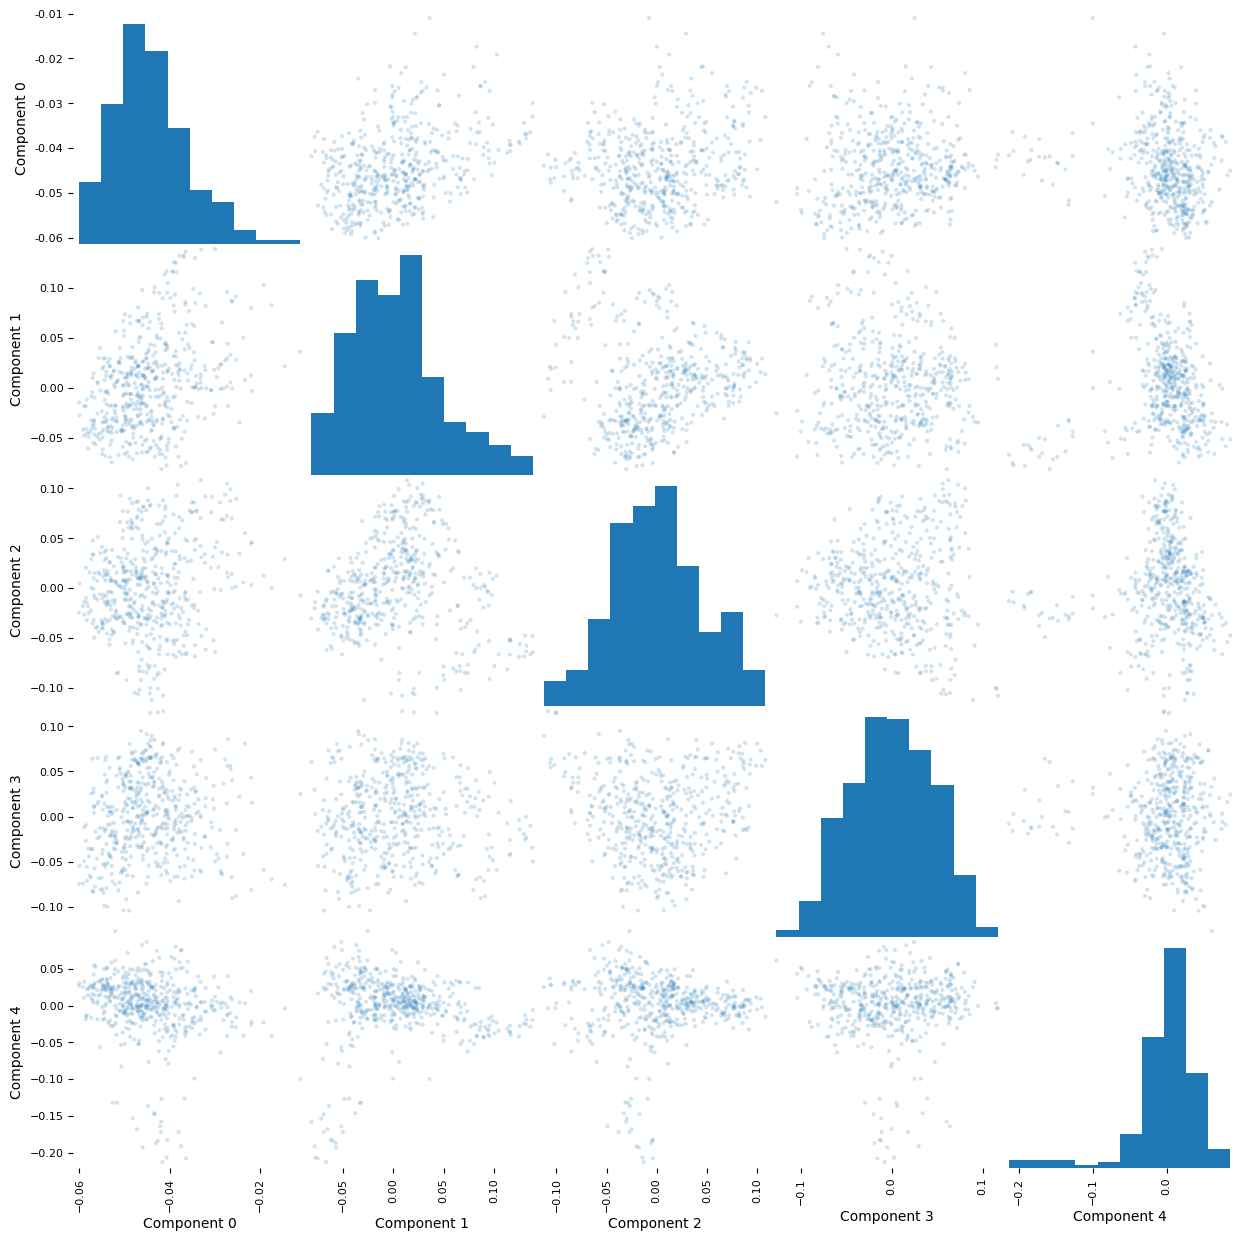

In [3]:
from arbitragelab.ml_approach import OPTICSDBSCANPairsClustering

ps = OPTICSDBSCANPairsClustering(prices_df)

# Here the first parameter is the number of features to reduce to.
ps.dimensionality_reduction_by_components(5)

# The following will plot the feature vector from the previous method call.
ps.plot_pca_matrix();

#### Unsupervised Learning

**OPTICS 군집화 알고리즘 적용하기**

- 군집의 개수를 직접 적용해줄 필요가 없다
- 이상치에 대해서 강건한 특성을 가지고 있다
- 다양한 밀도의 군집에 적합한 알고리즘이다

첫 번째 방법은 OPTICS 알고리즘을 적용하고, 각 군집마다 더 알맞는 $\epsilon$ 값을 알아서 탐색해 적용해주는 것이다

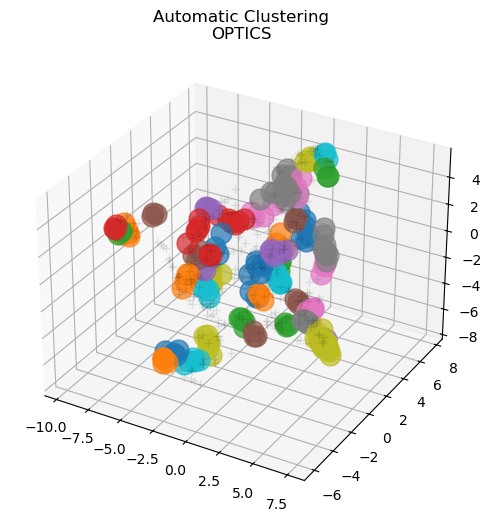

In [6]:
clustered_pairs = ps.cluster_using_optics(min_samples = 3)
ps.plot_clustering_info(method = 'OPTICS', n_dimensions = 3, figsize = (6, 6))
plt.show()

### DBSCAN 군집화 알고리즘

두 번째 알고리즘은 바로 DBSCAN을 사용하는 것이다. 이는 사용자가 알고리즘의 parameter 민감도가 주어진 결과를 향상시킬 수 있는 도메인별 지식을 이미 가지고 있을 때 사용된다. 설명된 $\epsilon$ 을 찾는 가능한 접근 방법은 `knee plot`을 보고 전역 변곡점을 관찰해서, 적합한 $\epsilon$을 찾아가는 것이다.

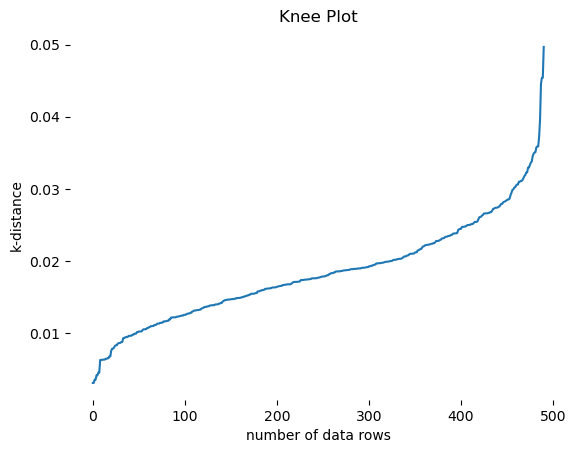

In [9]:
ps.plot_knee_plot()
plt.xlabel('number of data rows')
plt.show()

다음은 서로 다른 $\epsilon$ 값을 사용한 DBSCAN 군집화의 예시 결과로, `knee plot`과 서로 다른 'k-distance' 값에서 방법의 효율성을 보여준다

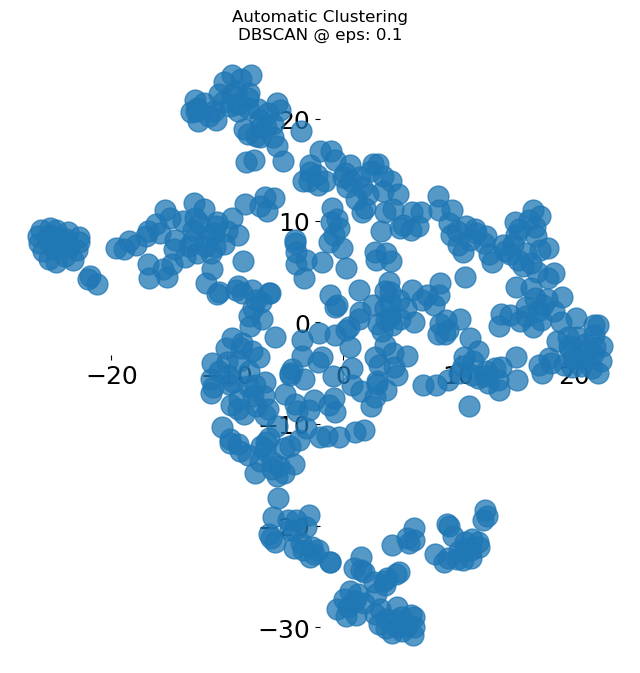

In [15]:
ps.cluster_using_dbscan(
    eps = 0.1, # epsilon = 0.1
    min_samples = 3, 
    metric = 'euclidean'
)
ps.plot_clustering_info(
    method = 'DBSCAN @ eps: 0.1', 
    figsize = (8,8)
)
plt.show()

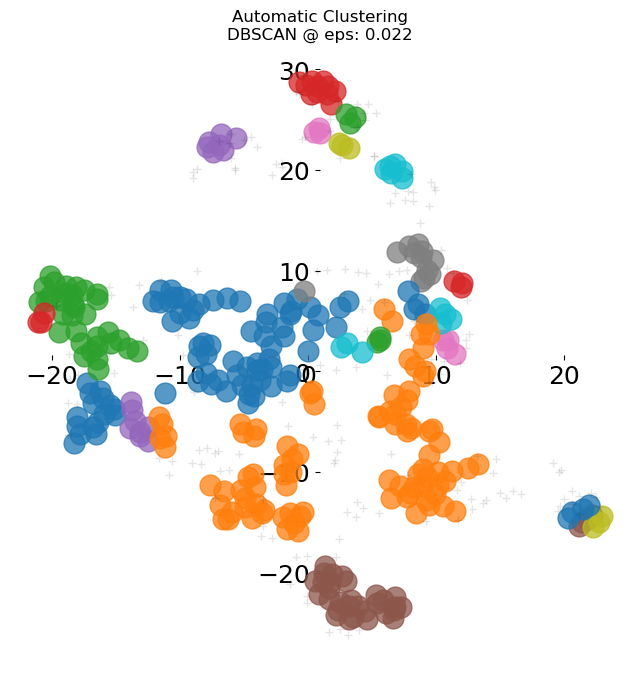

In [11]:
ps.cluster_using_dbscan( 
    eps = 0.022, # epsilon = 0.022
    min_samples = 3, 
    metric = 'euclidean'
)
ps.plot_clustering_info(
    method = 'DBSCAN @ eps: 0.022', 
    figsize = (8,8)
)

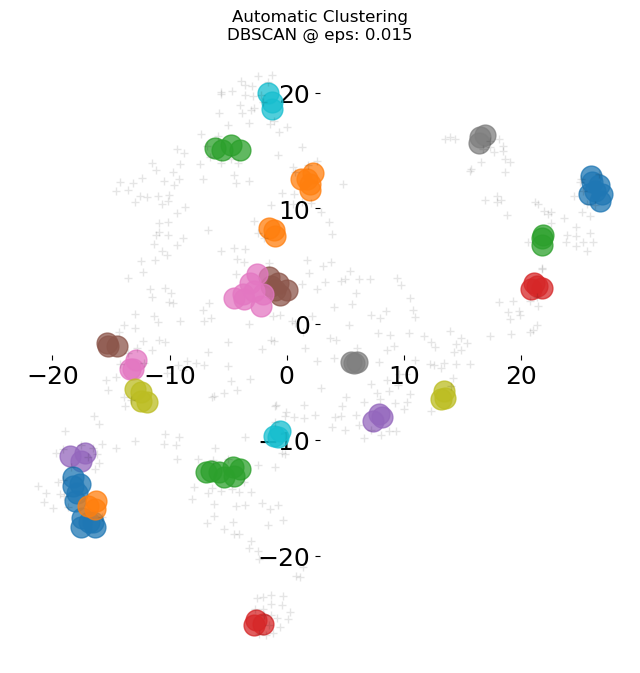

In [17]:
ps.cluster_using_dbscan(
    eps = 0.015, # epsilon = 0.015
    min_samples = 3, 
    metric = 'euclidean'
)
ps.plot_clustering_info(
    method = 'DBSCAN @ eps: 0.015', 
    figsize = (8,8)
)
plt.show()

### Pair Selection

**아래 규칙을 이용한 종목 페어쌍 찾기**

Sarmento와 Horta는 미래에도 가격이 평균으로 되돌아올 가능성을 높이기 위해 잠재적인 쌍을 추가로 필터링하기 위한 네 가지 기준을 제안합니다.

- Engle-Granger 테스트를 사용한 공적분: pair 사이에 cointegration이 존재하는지 확인한다.
- 허스트 지수 ($H$): 평균 회귀성을 위해 (스프레드의) $H < 0.5$인 pair를 유지한다.
- half life : (스프레드의) 반감기가 1일에서 1년 사이인 pair을 유지한다.
- 연간 평균 교차 횟수 최소값: (스프레드가) 연간 평균 12회 이상 교차하는 쌍을 유지한다.

이 네 가지 기준은 잠재적인 거래 가능한 증권 쌍의 매력적인 특성을 나타낸다. Engle-Granger 테스트는 pair의 cointegration 관계를 테스트한다. 0.5 미만의 허스트 지수는 가격 쌍이 평균으로 강하게 회귀함을 나타낸다. 여기서 반감기 값이 1 이하 또는 356 이상인 쌍은 제외된다. 극단적인 반감기 값은 가격 시계열이 너무 빨리 또는 너무 느리게 되돌아와 거래하기에 부적합함을 나타낸다. 마지막으로, 가격 시계열은 연간 평균 12회 이상 장기 스프레드 평균을 교차해야 한다.

In [18]:
clustered_pairs = list(
    set(clustered_pairs)
)

In [19]:
# Load data into spread selector
sp = al.spread_selection.CointegrationSpreadSelector(
    prices_df = prices_df,
    baskets_to_filter = clustered_pairs
)
                                                    
# Filtered spreads that passed the criteria by specifying hedge ratio calculation method as well as filtering conditions.
filtered_spreads = sp.select_spreads()

Spread construction: |██████████████████████████████████████████████████| 100.0% Complete
Statistics generation: |██████████████████████████████████████████████████| 100.0% Complete


In [21]:
# The module can also work with user-specified spreads to test if a spread passes cointegration selection criterion.
spread = sp.spreads_dict['AAL_FTI'].copy() # Let's take an arbitrary spread.
pairs_selector_custom = al.spread_selection.CointegrationSpreadSelector(prices_df=None, baskets_to_filter=None)
stats = pairs_selector_custom.generate_spread_statistics(spread, log_info=True) # log_info=True to save stats.

In [22]:
stats

{'coint_t': -3.3117820049633235,
 'p_value_99%': -3.435621806786881,
 'p_value_95%': -2.8638680226791444,
 'p_value_90%': -2.5680094689100477,
 'hurst_exponent': 0.38669280381361,
 'half_life': 39.716464348315256,
 'crossovers': 63}

In [23]:
filtered_spreads_custom = pairs_selector_custom.apply_filtering_rules(
    adf_cutoff_threshold = 0.9, 
    hurst_exp_threshold = 0.5
)

In [24]:
filtered_spreads_custom

array(['AAL_FTI'], dtype=object)

In [25]:
# checking result spreads
filtered_spreads

array(['AAL_FTI', 'AAL_IVZ', 'AAL_TPR', ..., 'WMB_WRK', 'WMB_ZBH',
       'WMB_ZION'], dtype=object)

In [26]:
len(filtered_spreads)

1656

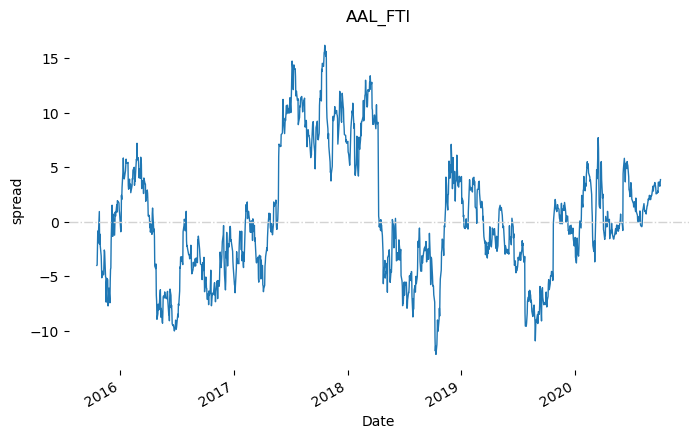

In [32]:
sp.spreads_dict['AAL_FTI'].plot(figsize = (8, 5), lw = 1)
plt.title('AAL_FTI')
plt.ylabel('spread')
plt.axhline(y = 0, color = 'lightgray', ls = '-.', lw = 1)
plt.show()

In [34]:
sp.selection_logs.loc[['AAL_FTI']].T # statistics

,AAL_FTI
coint_t,-3.311782
p_value_99%,-3.435622
p_value_95%,-2.863868
p_value_90%,-2.568009
hurst_exponent,0.386693
half_life,39.716464
crossovers,63
hedge_ratio,"{'AAL': 1.0, 'FTI': 1.4315981789941745}"


### Conclusion

이번 장에서는 제안된 pair selection framework를 설명하고, 검색 공간을 효율적으로 줄이고 양질의 거래 페어를 선택하기 위한 구현된 프레임워크의 사용 예시를 보여준다

여기에서는 10년 간의 400개 증권에 대한 일일 주가 데이터를 PCA를 통해 5차원으로 축소했는데, 클러스터에서 나온 1643개의 스프레드가 네 가지 선택 기준을 충족했다

**주요 요점**

- 트레이더가 처리해야 할 페어 수는 전체 자산 유니버스의 열린 조합 검색을 통해 생성된 페어 수보다 훨씬 적다. 
- (이전 연구에 따르면) 프레임워크 어디에서도 명시적 산업/섹터 그룹화가 없었음에도 불구하고, 대부분의 최종 선택된 페어는 예상된 경제적 섹터 클러스터를 따른다.

**일반적인 함정에 대한 해결책**

- 차원 축소 기술은 신뢰성 있게 작동하기 위해 일정량의 데이터가 필요하므로, 이 지점에서 불안정성이 발생하면 데이터 양을 늘리는 것이 좋다. 
- PCA 구성 요소의 수는 설명된 분산의 양과 유클리드 거리 밀도의 균형을 맞춰야 한다. 
- 경험적으로 15개 이하의 구성 요소를 사용하는 것이 좋다.
- 의심스러울 때는 OPTICS를 사용한다.
- 클러스터링 방법의 경우, 'minimum_samples' attribute는 생성된 클러스터가 균질하게 되도록 충분히 커야 한다. 경험적으로 3보다 큰 숫자가 좋다.